# Curso BancoEstado-CMM: Aprendizaje de Máquinas Avanzado 
**Autores:** Taco de Wolff y Felipe Tobar  

**Fecha:** 22 noviembre, 2019


# Módulo 7 - Introducción de regresión logística y SVM
Contenidos:
- Ejemplo regresión logística
- Ejemplo SVM

# Regresión Logística

Este notebook es un demo de como implementar regresión logística de 2 formas, la primera es definir la verosimilitud como una función y optimizar usando BFGS, la segunda es usando funciones de sklearn.

### Modelo

Comenzamos definiendo el modelo de regresión logística, donde de la probabilidad de la clase $y$, condicional a los datos $x$ y los pesos $w$ es,

$$p(y_i|x_i, \mathbf{w}) = \text{Ber}(y_i|\sigma(\mathbf{w}x_i)) = \sigma(\mathbf{w}x_i)^{y_i} (1- \sigma(\mathbf{w}x_i))^{1-y_i} $$

De esta forma, podemos expresar la log verosimilitud negativa, en función de los datos $x$ y parametros $w$,


$$ NLL = J(\mathbf{w}) = \sum_{i=1}^{D}y_i \log \sigma(\mathbf{w}x_i) + (1-y_i)\log(1-\sigma(\mathbf{w}x_i))$$

Utilizaremos __máxima verosimilitud__, pero __no__ tenemos expresión analítica para los pesos $w$ óptimos, por lo que deberemos utilizar métodos de optimización numérica, en particular optimizaremos usando BFGS.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# contexto notebook  y escala de fuente
sns.set_context('notebook', font_scale=1.4)

# estilo, fondo blanco con 'ticks' en los ejes
sns.set_style('ticks')

# tamaño por defecto de las figuras
plt.rcParams['figure.figsize'] = (10, 5)

### Cargamos datos y dividimos en entrenamiento y test

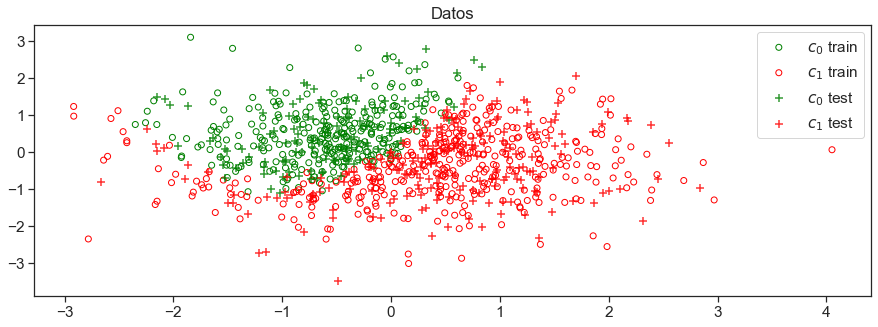

In [20]:
# funcion para dividir entre entrenamiento y test
from sklearn.model_selection import train_test_split

# cargar datos
data = np.loadtxt('datos_reg_log.txt', delimiter=',')

# dividimos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    data[:2, :].T, data[2, :].T, test_size=0.33)

# graficamos
plt.figure(figsize=(15,5))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], edgecolors='g', marker='o', facecolors='none', label=r'$c_0$ train')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], edgecolors='r', marker='o', facecolors='none', label=r'$c_1$ train')
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='g', marker='+', s=50, alpha=0.8, label=r'$c_0$ test')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='r', marker='+', s=50, alpha=0.8, label=r'$c_1$ test')
plt.legend()
plt.title('Datos');

## Opción 1: Hecho a mano

Creamos el modelo definiendo funciones:
1. Sigmoidea
2. Log verosimilitud negativa (NLL) para regresion logística.
3. El jacobiano de (2)
4. Optimizamos NLL mediante BFGS

### Definición modelo

In [21]:
def sig(w, x):
    """
    Retorna la sigmoidea de (w @ x)
    """
    # agrego fila de unos
    x_tilda = np.c_[np.ones(x.shape[0]), x]
    a = x_tilda @ w
    
    return 1 / (1 + np.exp(-a))

def rl_nll(w, x, y):
    """
    Log verosimilitud negativa del modelo de
    regresión logística.
    """
    # log verosimilitud negativa
    nll = -(y * np.log(sig(w, x)) + (1 - y) * np.log(1 - sig(w, x))).sum()
    
    return nll

def jac_nll(w, x, y, rho=0.1):
    """
    Jacobiano de la NLL.
    """
    x_tilda = np.c_[np.ones(x.shape[0]), x]
    
    return ((sig(w, x) - y) @ x_tilda)

### Optimizar

Optimizamos la log-verosimilitud-negativa usando BFGS

In [22]:
# optimizador de scipy
from scipy.optimize import minimize as fmin

# condicion inicial
w0 = np.zeros(X_train.shape[1] + 1) + 1e-6
# argumentos
args = (X_train, y_train)

opt = fmin(
    rl_nll,                  # funcion objetivo
    w0,                      # condicion inicial
    args,                    # argumentos fijos funcion objetivo
    jac=jac_nll,             # gradientes
    method='BFGS',           # metodo
    tol=1e-8,                # tolerancia numerica
    options={'disp': True, 'maxiter': 8000}) # opciones extra

w_opt = opt.x
print('Pesos optimos (hecho a mano)', w_opt)
print('NLL', opt.fun)

         Current function value: 238.868263
         Iterations: 17
         Function evaluations: 83
         Gradient evaluations: 71
Pesos optimos (hecho a mano) [ 0.60977753  2.04698149 -2.22763044]
NLL 238.86826338503042


/Users/felipe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/felipe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


### Predicción
Realizamos predicción

In [23]:
def lr_predict(w, x, tresh=0.5):
    """
    Prediccion para regresión logística
    """
    # probabilidad de clase data el modelo y obs
    p_y_w = sig(w, x)
    
    # asigna clase segun umbral
    y_pred = (p_y_w >= tresh).astype(int)
    
    return y_pred

y_pred1 = lr_predict(w_opt, X_test)

In [24]:
# metrica de accuracy
from sklearn.metrics import accuracy_score

print('Pesos optimos (hecho a mano)', w_opt)
print('Accuracy en conjunto de test (hecha a mano)', accuracy_score(y_test, y_pred1))

Pesos optimos (hecho a mano) [ 0.60977753  2.04698149 -2.22763044]
Accuracy en conjunto de test (hecha a mano) 0.8666666666666667


## Opcion 2: Sklearn

Importamos y aplicamos la función

In [25]:
# importamos de sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# crear instancia
logr = LogisticRegression(solver='lbfgs', fit_intercept=True)

# entrenar
logr.fit(X_train, y_train)

# predecir
y_pred2 = logr.predict(X_test)

# mostrar pesos optimos
print('Pesos optimos sklearn', logr.intercept_, logr.coef_)

print('Accuracy en conjunto de test (sklearn)', accuracy_score(y_test, y_pred2))

Pesos optimos sklearn [0.58407297] [[ 1.94645144 -2.11479527]]
Accuracy en conjunto de test (sklearn) 0.8666666666666667


## Gráfico comparativo de ambas implementaciones

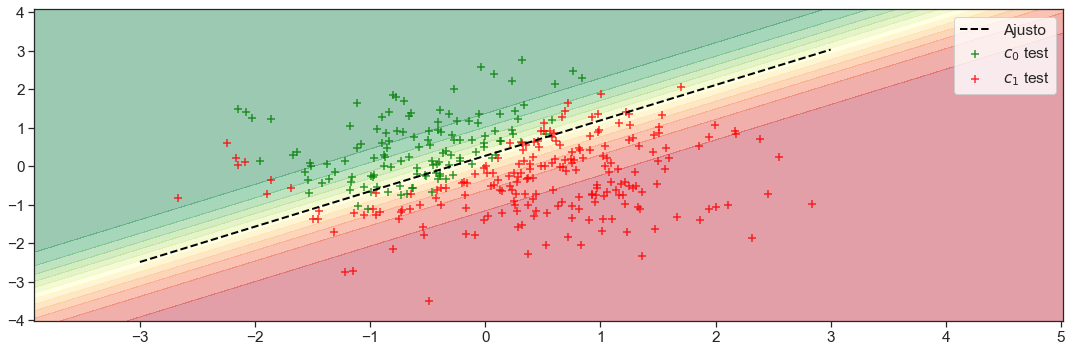

In [26]:
# plano encontrado
line_x = np.linspace(-3, 3, 2)
line_y = -opt.x[1] / opt.x[2] * line_x - opt.x[0] / opt.x[2]
line_y2 = -logr.intercept_ / logr.coef_[0][1] - logr.coef_[0][0] / logr.coef_[0][1] * line_x

# grid de puntos para graficar region
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.06),
                     np.arange(y_min, y_max, 0.06))

# clasificar grid
Z = -sig(w_opt, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15,5))
plt.contourf(xx, yy, Z, alpha=0.4, levels = 15, cmap='RdYlGn')#, vmin=-1, vmax=0)

#plt.imshow( Z, cmap='coolwarm')#, vmin=-1, vmax=0)

plt.plot(line_x, line_y, '--k', lw=2, label='Ajusto')
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='g', marker='+', s=50, alpha=0.8, label=r'$c_0$ test')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='r', marker='+', s=50, alpha=0.8, label=r'$c_1$ test')
plt.legend()

plt.tight_layout()

In [42]:
def sig(w, x):
    """
    Retorna la sigmoidea de (w @ x)
    """
    # agrego fila de unos
    x_tilda = np.c_[np.ones(x.shape[0]), x]
    a = x_tilda @ w
    
    return 1 / (1 + np.exp(-a))

def likelihood(w,x=X_train,y=y_train):
    return ((sig(w,x))**(y)*(1-sig(w,x))**(1-y)).prod()

prior = 1/50 * 1/50 * 1/50
def mh_sampler(n_iter=100, y_obs=y_train, x0=None, tau=2):
    """
    Metropolis Hastings sampler.
    
    n_iter : Número de iteraciones.
    y_obs : Observaciones.
    x0 : Punto inicial
    tau : varianza del proposal.
    """
    # si no especifico punto inicial, saca uno al azar
    N = len(logr.coef_[0])+1
    if x0 is None:
        x0 = np.random.normal(size=(1,N))
    
    # contenedor para guardar las muestras
    W = np.zeros((n_iter + 1,N))
    # asigno primer valor
    W[0,:] = x0
    
    for it in range(1, n_iter + 1):
        # generar proposal
        w_c = np.random.normal(W[it - 1], tau)
        
        # probabilidad aceptacion
        num = likelihood(w_c) * prior
        denom = likelihood(W[it - 1]) * prior
        # probabilidad
        r = min(num / denom, 1)
        
        # realizacion Bernoulli para aceptar
        accept = np.random.random() < r
        
        if accept:
            W[it] = w_c
        else: 
            W[it] = W[it - 1]

    return W

chain1 = mh_sampler(15000, tau=1)

In [43]:
print(logr.intercept_)
print(logr.coef_)

[0.58407297]
[[ 1.94645144 -2.11479527]]


Text(0.5, 1.0, 'alpha chain 1 histogram')

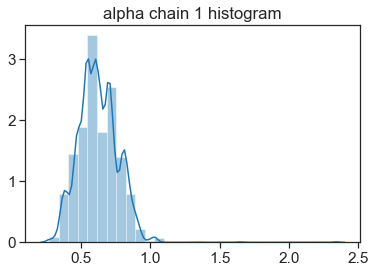

In [44]:
sns.distplot(chain1[:,0],bins=30)
plt.title("alpha chain 1 histogram")

Text(0.5, 1.0, 'alpha chain 1 histogram')

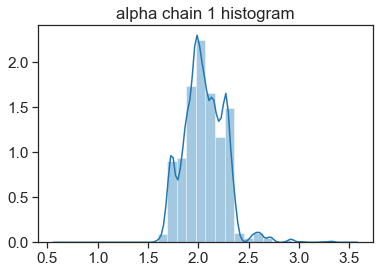

In [45]:
sns.distplot(chain1[:,1],bins=30)
plt.title("alpha chain 1 histogram")

Text(0.5, 1.0, 'alpha chain 1 histogram')

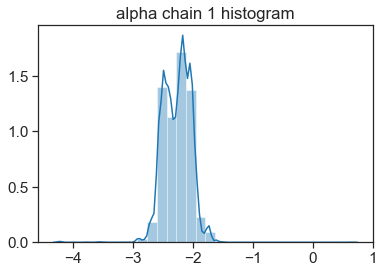

In [46]:
sns.distplot(chain1[:,2],bins=30)
plt.title("alpha chain 1 histogram")

(-2.5, 2.5)

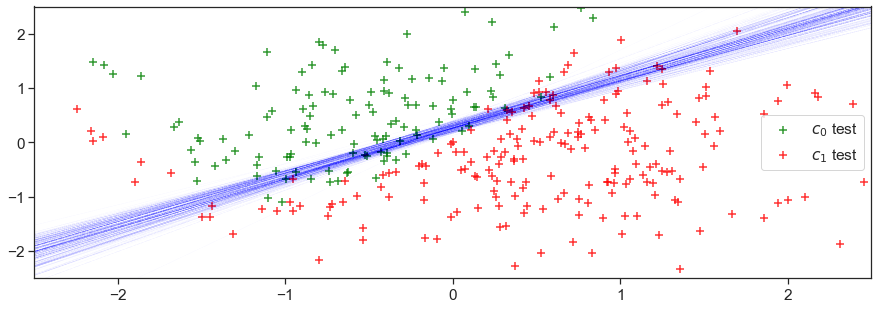

In [51]:
plt.figure(figsize=(15,5))

plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='g', marker='+', s=50, alpha=0.8, label=r'$c_0$ test')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='r', marker='+', s=50, alpha=0.8, label=r'$c_1$ test')

for i in range(1000):
    idx = np.random.randint(0, chain1.shape[0])
    line_x = np.linspace(-3, 3, 2) 
    line_y = -chain1[idx,0] / chain1[idx,2] - chain1[idx,1] / chain1[idx,2] * line_x  
    plt.plot(line_x, line_y, '-b', lw=0.5, alpha=0.01)
plt.legend();

plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])

## Datos reales: Breast cancer wisconsin

Para mostrar con un dataset más realista, se quiere clasificar si un paciente presenta cancer o no dado ciertas mediciones.

In [52]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
print(data.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [53]:
# mostrar nombres de cada feature
print(data.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.33, random_state=42)

In [55]:
# crear instancia
logr = LogisticRegression(solver='lbfgs', max_iter=5000)

# entrenar
logr.fit(X_train, y_train)
logr.coef_

# predecir
y_pred3 = logr.predict(X_test)

In [56]:
print('Accuracy en conjunto test', accuracy_score(y_test, y_pred3))

Accuracy en conjunto test 0.9680851063829787


Text(0.5, 1.0, 'peso por atributo')

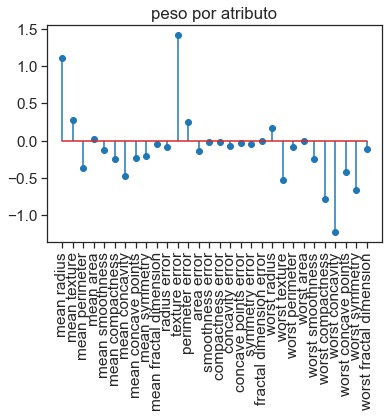

In [57]:
plt.stem(logr.coef_.T, use_line_collection=True);
plt.xticks(np.arange(30),labels=data.feature_names,rotation='vertical');
plt.title('peso por atributo')

# Support Vector machines

Aplicamos la clasificación con support vector machines en dos ejemplos:
1. Con la función de decisión XOR.
2. Clasificación si usuario de red social compra o no producto.

## Ejemplo 1: XOR

In [177]:
# numero de puntos
n = 2000

# medias 
mean_A = np.array([0, 0])

# matriz covarianza
std = np.eye(2)

# crea datos de una N(0, I) en 2 dim
X= np.random.multivariate_normal(mean_A, std, size =n)

# crea etiquetas
y = np.zeros(n)

for i in range(n):
    if X[i][0]*X[i][1] >= 0:
        y[i]=1
    else:
        y[i]= 0

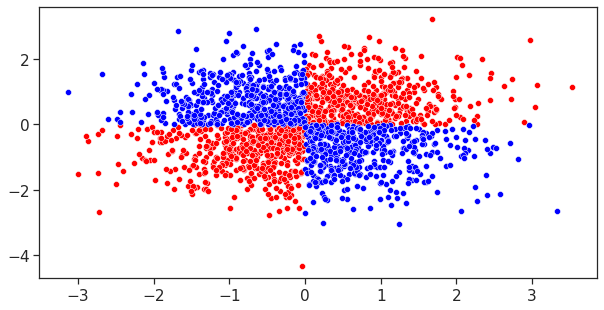

In [179]:
grupo1 = X[y==1]
grupo2 = X[y==0]

plt.scatter(grupo1[:,0], grupo1[:,1], c='red', edgecolor='w', linewidth=0.5)
plt.scatter(grupo2[:,0], grupo2[:,1], c='blue', edgecolor='w', linewidth=0.5)

In [180]:
# Separamos los datos en entrenamiento y validación
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Es importante escalar los datos al usar SVM
from sklearn.preprocessing import StandardScaler

# crea instancia
sc = StandardScaler()

# entrena y transforma
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [181]:
# Entrenamos el clasificador, para ello usamos SVC (Support Vector classifier)
from sklearn.svm import SVC

# instancia clasificador
classifier = SVC(kernel = 'rbf', degree =5, random_state = 0,verbose=True)

# entrena
classifier.fit(X_train, y_train);

[LibSVM]

In [182]:
#Generamos predicciones con nuestros datos
y_pred = classifier.predict(X_test)

In [183]:
#Vemos que tal nuestros scores
from sklearn.metrics import classification_report, classification, accuracy_score

vmat = classification.confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97       250
         1.0       0.95      0.99      0.97       250

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



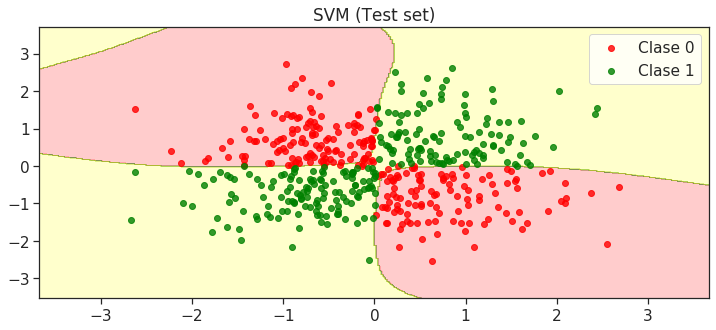

In [184]:
# SVM# Visualizamos nuestros resultados en el set de validación
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.02),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.02))


plt.figure(figsize=(12, 5))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.2, cmap = ListedColormap(('red', 'green','yellow')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

colorlist = ['red', 'green']
for i in range(2):
    plt.scatter(X_set[y_set == i, 0], X_set[y_set == i, 1],
                c=colorlist[i], label='Clase ' + str(i), alpha=0.8)
    
plt.title('SVM (Test set)')
plt.legend()
plt.show()

## Ejemplo 2: Social Network

Se tienen datos de una red social, donde se tiene sexo, edad, salario estimado y un perfil de ususario, y se quiere clasificador si son compradores de un producto o no (0 o 1).

In [185]:
import pandas as pd

# Importar el dataset
dataset = pd.read_csv('Social_Network_data.csv')
X = dataset.iloc[:, [1,2,3]].values
y = dataset.iloc[:, 4].values

In [187]:
#La primera variable y la segunda son categóricas
X

#La primera es el perfil memero (De 5): 4 chan, normie, Fedora, nihilista o dank

array([['Male', 19, 19000],
       ['Male', 35, 20000],
       ['Female', 26, 43000],
       ...,
       ['Female', 50, 20000],
       ['Male', 36, 33000],
       ['Female', 49, 36000]], dtype=object)

In [188]:
#Codificamos variables binarias categoricas (como sexo por ejemplo), usando LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
X

array([[1, 19, 19000],
       [1, 35, 20000],
       [0, 26, 43000],
       ...,
       [0, 50, 20000],
       [1, 36, 33000],
       [0, 49, 36000]], dtype=object)

In [189]:
#Para variables categoricas que no sean binarias, primero se ocupa labelencoder...
X[:,0]=labelencoder_X.fit_transform(X[:, 0])
X

array([[1, 19, 19000],
       [1, 35, 20000],
       [0, 26, 43000],
       ...,
       [0, 50, 20000],
       [1, 36, 33000],
       [0, 49, 36000]], dtype=object)

In [190]:
X[1]

array([1, 35, 20000], dtype=object)

In [191]:
#Y despues One-Hot_encoder 
onehotencoder = OneHotEncoder(categories='auto')
#En categorical_features se coloca un arreglo en donde van las columnas de variables categoricas (En este caso solo la primera columna)

X = onehotencoder.fit_transform(X).toarray()

In [192]:
X[1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [193]:
# Separamos los datos en entrenamiento y validación
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Es importante escalar los datos al usar SVM
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [194]:
# Entrenamos el clasificador, para ello usamos SVC (Support Vector classifier)
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0,verbose=True, gamma='scale')
classifier.fit(X_train, y_train);

[LibSVM]

In [195]:
#Generamos predicciones con nuestros datos
y_pred = classifier.predict(X_test)

In [196]:
#Vemos que tal nuestros scores
from sklearn.metrics import classification_report, classification, accuracy_score
vmat = classification.confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        58
           1       0.67      0.73      0.70        22

    accuracy                           0.82        80
   macro avg       0.78      0.79      0.79        80
weighted avg       0.83      0.82      0.83        80

